In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torch torchvision einops tqdm pytorch-lightning scikit-learn
!git clone https://github.com/ucaswangls/EfficientSCI.git

import sys
sys.path.append("/content/EfficientSCI")

fatal: destination path 'EfficientSCI' already exists and is not an empty directory.


In [3]:
# imports
import os
import gc
import re
import glob
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imageio
from imageio import get_writer
from tqdm import tqdm
import pandas as pd
from pytz import timezone
from datetime import datetime, timedelta
from cacti.models.efficientsci import EfficientSCI
import matplotlib.gridspec as gridspec
from skimage.metrics import structural_similarity as ssim_fn


In [4]:
#Compute rmse
def compute_rmse(x_true, x_pred):
  x_true = x_true.astype(np.float64)
  x_pred = x_pred.astype(np.float64)
  rmse = np.sqrt(np.mean((x_true - x_pred) ** 2))
  return rmse

#Compute the psnr
def compute_psnr(x_true, x_pred, max_val=None):
  mse = np.mean((x_true - x_pred) ** 2)
  if mse == 0:
    return float('inf')
  if max_val is None:
    max_val = np.max(x_true)
  psnr = 10 * np.log10((max_val ** 2)/ (mse+ 1e-8))
  return psnr

#Compute ssim
def compute_ssim(x_true, x_pred, max_val=None):
  x_true = x_true.astype(np.float64)
  x_pred = x_pred.astype(np.float64)

  if max_val is None:
    max_val = np.max(x_true)

  if x_true.ndim == 2:
    return ssim_fn(x_true, x_pred, data_range=max_val)
  elif x_true.ndim == 3:
    ssim_vals = [ssim_fn(x_true[i], x_pred[i], data_range=max_val) for i in range(x_true.shape[0])]
    return np.mean(ssim_vals)
  else:
    raise ValueError("Input is not 2D or 3D")

In [5]:
class SCIBlockDataset(Dataset):
    def __init__(self, file_list, patch_size=100, grid_size=1):
        self.file_list = file_list
        self.patch_size = patch_size
        self.grid_size = grid_size
        self.patches_per_block = grid_size ** 2

    def __len__(self):
        return len(self.file_list) * self.patches_per_block

    def __getitem__(self, idx):
        block_idx = idx // self.patches_per_block
        patch_idx = idx % self.patches_per_block

        data = np.load(self.file_list[block_idx], mmap_mode = 'r')
        y = data['y']
        y = np.nan_to_num(y, nan=0.0)
        if np.isnan(y).any():
          print("NaN detected in y before conversion")
        phi = data['phi']
        x = data['x']

        x = np.nan_to_num(x, nan=0.0)
        phi_s = np.sum(phi, axis=0, keepdims=True) #shape [1, H, W]

        T, H, W = x.shape
        ps = self.patch_size

        row = (patch_idx // self.grid_size) * ps
        col = (patch_idx % self.grid_size) * ps

        y_patch = y[row:row+ps, col:col+ps]
        x_patch = x[:, row:row+ps, col:col+ps]
        phi_patch = phi[:, row:row+ps, col:col+ps].copy()


        phi_s = np.sum(phi[:, row:row+ps, col:col+ps], axis=0, keepdims=True)
        #Normalize the x and y patches
        max_val = np.max(x_patch) + 1e-8 #all bands
        x_patch = x_patch / max_val

        x_patch = np.clip(x_patch, a_min=0, a_max=None) #NOT BAND 1
        x_patch = np.log1p(x_patch) #NOT BAND 1

        y_patch = y_patch / max_val
        phi_patch = phi_patch/max_val

        phi_s = phi_s/max_val

        if np.sum(phi_patch) == 0:
          phi_patch = 1

        return (torch.tensor(y_patch).unsqueeze(0).float(), torch.tensor(phi_patch).float(), torch.tensor(phi_s).float(),torch.tensor(x_patch).float(), torch.tensor(max_val).float())

In [6]:
reconstruction_only = False
reconstruction_and_original = True

band = 9
model_ckpt_path = f"/content/drive/MyDrive/Folder/Weights/efficientSCI_finetuned_band9_12hours.pth"
output_video_path = '/content/drive/MyDrive/reconstructed_video_band9_881_12hours_la.mp4'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_loc = 'la'
fps = 10
cmap = 'plasma'
timezone_name = 'US/Pacific'
start_time = datetime(2024,3,1,0,0)

all_files = sorted(glob.glob(f"/content/drive/MyDrive/Folder/data_blocks_12hours/band_{band:02d}/*.npz"))

test_files = [f for f in all_files if os.path.basename(f).startswith(f"{test_loc}")]

test_dataset = SCIBlockDataset(test_files, patch_size=100, grid_size=1)  # full patch
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=16,shuffle=False, pin_memory=True)
sample = next(iter(test_loader))
model = EfficientSCI().to(device)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loading Model from /content/drive/MyDrive/Folder/Weights/efficientSCI_finetuned_band9_12hours.pth


Reconstructing:   4%|▎         | 7/200 [00:02<00:41,  4.64it/s]/tmp/ipython-input-3708293914.py:15: RuntimeWarning: divide by zero encountered in log10
  psnr = 10 * np.log10((max_val ** 2)/ (mse+ 1e-8))
Reconstructing: 100%|██████████| 200/200 [00:18<00:00, 10.86it/s]


Average PSNR: 28.77
Average SSIM: 0.81
PSNR over all frames: 27.41 dB
RMSE over all frames: 0.52


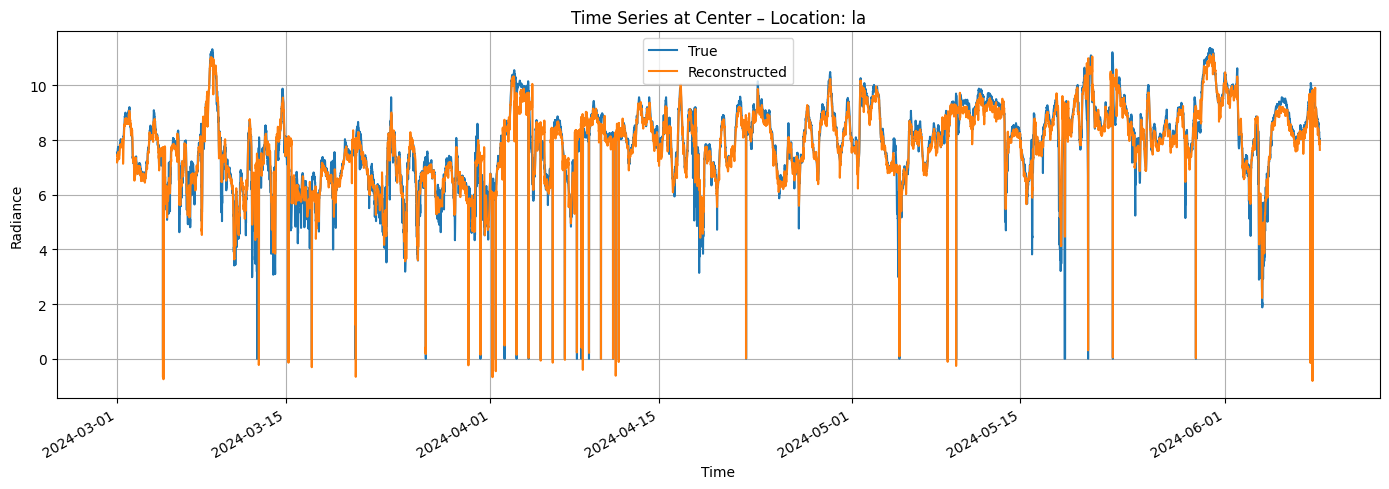

In [7]:
# Reconstruct model

print(f'Loading Model from {model_ckpt_path}')
model.load_state_dict(torch.load(model_ckpt_path, map_location=torch.device('cpu')))
model.to(device)
model.eval()

reconstructed_frames = []
timestamps = []
original_frames = []
psnr_list = []
rmse_list = []
ssim_list = []

true_ts_all = []
recon_ts_all = []

start_time = start_time
with torch.no_grad():
  for y, phi, phi_s, x_true, max_val in tqdm(test_loader, desc = 'Reconstructing'):
    y = y.to(device)
    phi = phi.to(device)
    phi_s = phi_s.to(device)
    max_val = max_val.to(device)
    x_true = x_true.to(device)

    x_pred = model(y, phi, phi_s)[0]

    x_pred = torch.expm1(x_pred) * max_val
    x_true = torch.expm1(x_true) * max_val

    x_pred = x_pred.cpu().numpy()
    x_true = x_true.cpu().numpy()

    assert x_pred.shape == x_true.shape, f"Shape mismatch: {x_pred.shape} vs {x_true.shape}"

    T, H, W = x_true.shape[1:]

    for b in range(x_pred.shape[0]):
      for t in range(x_pred.shape[1]):
        reconstructed_frames.append(x_pred[b,t])
        original_frames.append(x_true[b,t])
        timestamps.append(start_time +timedelta(minutes=10 *t))
        psnr_list.append(compute_psnr(x_true[b,t], x_pred[b,t]))
        rmse_list.append(compute_rmse(x_true[b,t], x_pred[b,t]))
        ssim_list.append(compute_ssim(x_true[b,t], x_pred[b,t]))

      h, w = H // 2, W // 2
      true_ts_all.append(x_true[b, :, h, w])
      recon_ts_all.append(x_pred[b, :, h, w])


torch.cuda.empty_cache()
gc.collect()

psnr_clean = [v for v in psnr_list if np.isfinite(v)]
average_psnr = np.mean(psnr_clean)
average_ssim = np.mean(ssim_list)

print(f"Average PSNR: {average_psnr:.2f}")
print(f"Average SSIM: {average_ssim:.2f}")

# Global PSNR
reconstructed_stack = np.stack(reconstructed_frames)
original_stack = np.stack(original_frames)

global_mse = np.mean((original_stack - reconstructed_stack) ** 2)
global_rmse = np.sqrt(global_mse)


global_max = np.max(original_stack)
global_psnr = 10 * np.log10((global_max ** 2) / (global_mse + 1e-8))
print(f"PSNR over all frames: {global_psnr:.2f} dB")
print(f"RMSE over all frames: {global_rmse:.2f}")


# Plot
true_ts_concat = np.concatenate(true_ts_all)
recon_ts_concat = np.concatenate(recon_ts_all)


frame_times = [start_time + timedelta(minutes=10 * i) for i in range(len(true_ts_concat))]

plt.figure(figsize=(14, 5))
plt.plot(frame_times, true_ts_concat, label="True")
plt.plot(frame_times, recon_ts_concat, label="Reconstructed", linestyle='-')
plt.title(f"Time Series at Center – Location: {test_loc}")
plt.xlabel('Time')
plt.ylabel('Radiance')
plt.grid()
plt.legend()
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()



In [8]:
#Get MP4 video
def create_mp4_from_frames(frames, filepath, cmap='plasma', fps=10, timestamps=None, timezone_name='US/Mountain'):

  filename = filepath

  vmin = np.nanmin(frames)
  vmax = np.nanmax(frames)

  print(f'Rendering MP4: {filename}')
  writer = get_writer(filename, fps=fps, codec = 'libx264')

  tz = timezone(timezone_name)
  start_time = datetime(2024,4,1)

  for i in tqdm(range(len(frames)), desc='Rendering'):
    fig, ax = plt.subplots(figsize = (5,5))
    canvas = FigureCanvas(fig)
    norm = Normalize(vmin=vmin, vmax=vmax)
    im = ax.imshow(frames[i], cmap=cmap, norm=norm)
    ax.axis('off')
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Radiance")

    if timestamps:
      frame_time = start_time + timedelta(minutes=10*i)
      local_time = pd.to_datetime(frame_time).tz_localize('UTC').tz_convert(tz)
      timestamp_str = local_time.strftime("%Y-%m-%d %H:%M %Z")
      ax.set_title(f"{base} - {timestamp_str}", fontsize=10, wrap=True)

    plt.tight_layout(pad=1)
    canvas.draw()
    image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
    image = image.reshape(canvas.get_width_height()[::-1] + (4,))
    writer.append_data(image)
    plt.close(fig)



  writer.close()
  print(f"Saved MP4: {filename}")
  return filename


In [9]:
def reconstructed_and_original_mp4(original_frames, reconstructed_frames, filepath, timestamps=None, timezone_name='US/Eastern', fps=10, cmap='plasma', starttime=start_time):
  assert len(original_frames) == len(reconstructed_frames), "Different number of frames!!! "
  writer = imageio.get_writer(filepath, fps=fps, codec='libx264')

  vmin = 0
  vmax = 20 #THIS WILL CHANGE DEPENDING ON THE RECONSTRUCTED BAND NUMBER

  norm = Normalize(vmin=vmin, vmax=vmax)
  tz = timezone(timezone_name)
  start_time = starttime

  for i in tqdm(range(len(original_frames)), desc='Rendering'):
    fig = plt.figure(figsize=(12, 5))
    canvas = FigureCanvas(fig)
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.03, 1], wspace=0)

    ax_orig = fig.add_subplot(gs[0, 0])
    ax_recon = fig.add_subplot(gs[0, 2])
    cax = fig.add_subplot(gs[0, 1])  # colorbar goes here

    # Show images
    im1 = ax_orig.imshow(original_frames[i], cmap=cmap, norm=norm)
    ax_orig.axis('off')
    ax_orig.set_title("Original Time Series", fontsize=10)

    im2 = ax_recon.imshow(reconstructed_frames[i], cmap=cmap, norm=norm)
    ax_recon.axis('off')
    ax_recon.set_title("Reconstructed Time Series", fontsize=10)

    # Colorbar
    cbar = fig.colorbar(im2, cax=cax)
    cbar.set_label("Radiance")

    if timestamps:
      frame_time = pd.to_datetime(timestamps[i])
    else:
      frame_time = start_time + timedelta(minutes=10*i)
    local_time = pd.to_datetime(frame_time).tz_localize('UTC').tz_convert(tz)
    timestamp_str = local_time.strftime("%Y-%m-%d %H:%M %Z")
    fig.suptitle(f'LA: {timestamp_str}', fontsize=12)

    plt.tight_layout(pad=1)
    canvas.draw()
    image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
    image = image.reshape(canvas.get_width_height()[::-1] + (4,))
    writer.append_data(image)
    plt.close(fig)

  writer.close()
  print(f"Saved MP4 of both Original and Reconstructed Time Series: {filepath}")




In [10]:
if reconstruction_only:
  create_mp4_from_frames(reconstructed_frames, output_video_path, cmap=cmap, fps=fps, timestamps=timestamps, timezone_name=timezone_name)

if reconstruction_and_original:
  reconstructed_and_original_mp4(original_frames, reconstructed_frames, output_video_path, timestamps=timestamps, timezone_name=timezone_name, fps=fps, cmap=cmap, starttime=start_time)

Rendering: 100%|██████████| 14382/14382 [29:13<00:00,  8.20it/s]


Saved MP4 of both Original and Reconstructed Time Series: /content/drive/MyDrive/reconstructed_video_band9_881_12hours_la.mp4
